<a href="https://colab.research.google.com/github/joaoBernardinoo/avoid-obstacle-collision/blob/main/controllers/cnn/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [329]:
import torch
import torch.nn as nn
import sys
import os
import h5py
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import KFold
from torchvision import transforms



In [315]:
%load_ext autoreload

%autoreload 2

from train import train_model
from models import LidarVisionFusionNet
from dataset import RobotDataset
from eval import evaluate_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
# @title Drive
if 'google.colab' in sys.modules:
  from google.colab import drive # type: ignore
  drive.mount('/content/drive')
  project_root = os.path.abspath(os.path.join(os.getcwd()))
  if project_root not in sys.path:
      sys.path.insert(0, project_root)
else:
  project_root = os.path.abspath(os.path.join(os.getcwd()))
  if project_root not in sys.path:
      sys.path.insert(0, project_root)

In [271]:

# matplotlib.use("notebook")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Configuration ---_
import sys

# Check if running in Colab
if 'google.colab' in sys.modules:
    SCRIPT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/cnn")
    DATASET_PATH = SCRIPT_DIR / 'merged_dataset.h5'
    BATCH_SIZE = 256
    print(f"Running in Google Colab. SCRIPT_DIR set to: {SCRIPT_DIR}, DATASET_PATH set to: {DATASET_PATH}, BATCH_SIZE set to: {BATCH_SIZE}")
else:
    SCRIPT_DIR = Path.cwd()
    DATASET_PATH = SCRIPT_DIR / 'cnn_dataset' / 'cnn_dataset.h5'
    BATCH_SIZE = 64
    print(f"Running in local environment (VS Code?). SCRIPT_DIR set to: {SCRIPT_DIR}, DATASET_PATH set to: {DATASET_PATH}, BATCH_SIZE set to: {BATCH_SIZE}")

# Diretório para salvar os checkpoints
CHECKPOINT_DIR = SCRIPT_DIR / 'checkpoints'
PLOT_SAVE_PATH = SCRIPT_DIR / 'training_history.png'
MODEL_PATH = SCRIPT_DIR / 'lvf.pth'
# Cria o diretório de checkpoints se ele não existir
CHECKPOINT_DIR.mkdir(exist_ok=True)

# Image dimensions
IMG_HEIGHT = 40
IMG_WIDTH = 200
IMG_CHANNELS = 4  # BGRA from Webots

# Training parameters
EPOCHS = 40
LEARNING_RATE = 1e-4
N_SPLITS = 5  # Número de folds para K-Fold

DIST_SCALE = 3.14
ANGLE_SCALE = np.pi
LIDAR_MAX_VAL = 3.14

Using device: cuda
Running in local environment (VS Code?). SCRIPT_DIR set to: /home/dino/Documents/ia/controllers/cnn, DATASET_PATH set to: /home/dino/Documents/ia/controllers/cnn/cnn_dataset/cnn_dataset.h5, BATCH_SIZE set to: 64


In [284]:
def load_data(path: Path, max_samples=None):
    """
    Carrega o dataset de um único arquivo HDF5.
    """
    if not path.exists() or not path.is_file():
        print(f"Error: HDF5 file not found at '{path}'")
        raise FileNotFoundError

    with h5py.File(path, 'r') as hf:
        if 'camera_image' not in hf:
            print(f"Error: 'camera_image' dataset not found in '{path}'")
            raise ValueError

        print(f"Loading samples from '{path}'...")
        X_cam = np.array(hf['camera_image'], dtype=np.float32)[:,:,:,:3]
        X_lidar = np.array(hf['lidar_data'], dtype=np.float32)
        dist = np.array(hf['dist'], dtype=np.float32)
        angle = np.array(hf['angle'], dtype=np.float32)

        if max_samples:
            X_cam = X_cam[:max_samples]
            X_lidar = X_lidar[:max_samples]

    X_lidar[np.isinf(X_lidar)] = LIDAR_MAX_VAL
    X_lidar /= LIDAR_MAX_VAL

    # --- NORMALIZE TARGETS (y) ---_
    dist /= DIST_SCALE
    angle /= ANGLE_SCALE
    dist.clip(-1, 1)
    angle.clip(-1,1)

    return (X_cam, X_lidar), (dist,angle)

In [316]:
lvf = LidarVisionFusionNet().to(device)  
print(lvf)

LidarVisionFusionNet(
  (vision_transforms): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (vision_branch): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2):

In [335]:
full_dataset = RobotDataset(DATASET_PATH, vision_transform=lvf.vision_transforms)
val_split = 0.2
dataset_size = len(full_dataset)
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size

print(f"Dataset completo: {dataset_size} amostras")
print(f"Divisão de Treino: {train_size} amostras")
print(f"Divisão de Validação: {val_size} amostras")
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)


Dataset completo: 1813 amostras
Divisão de Treino: 1451 amostras
Divisão de Validação: 362 amostras


In [336]:
BATCH_SIZE = 64

# O DataLoader de treino deve ser embaralhado para melhorar o aprendizado
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4 # Use múltiplos workers para carregar dados mais rápido
)

# O DataLoader de validação não precisa ser embaralhado
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)


In [337]:
history = train_model(lvf, train_loader, val_loader, EPOCHS)

Using device: cuda
Mixed Precision Training (AMP): Enabled


Epoch 1/40 [Train]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1/40 [Train]:   0%|          | 0/23 [00:00<?, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torch/utils/data/dataset.py", line 416, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "<string>", line 13, in __getitem__
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torchvision/transforms/_presets.py", line 58, in forward
    img = F.resize(img, self.resize_size, interpolation=self.interpolation, antialias=self.antialias)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torchvision/transforms/functional.py", line 465, in resize
    _, image_height, image_width = get_dimensions(img)
                                   ^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torchvision/transforms/functional.py", line 80, in get_dimensions
    return F_pil.get_dimensions(img)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dino/Documents/ia/.venv/lib/python3.12/site-packages/torchvision/transforms/_functional_pil.py", line 31, in get_dimensions
    raise TypeError(f"Unexpected type {type(img)}")
TypeError: Unexpected type <class 'numpy.ndarray'>


In [289]:
X_test, y_test = load_data(SCRIPT_DIR / "cnn_dataset"/ "cnn_test.h5")

Loading samples from '/home/dino/Documents/ia/controllers/cnn/cnn_dataset/cnn_test.h5'...


__len__ called. self.camera_images.shape: (342, 40, 200, 3)
Distance - MSE: 738.4347, MAE: 24.8258
Angle - MSE: 64.6111, MAE: 5.3325

Plot saved to evaluation_results.png


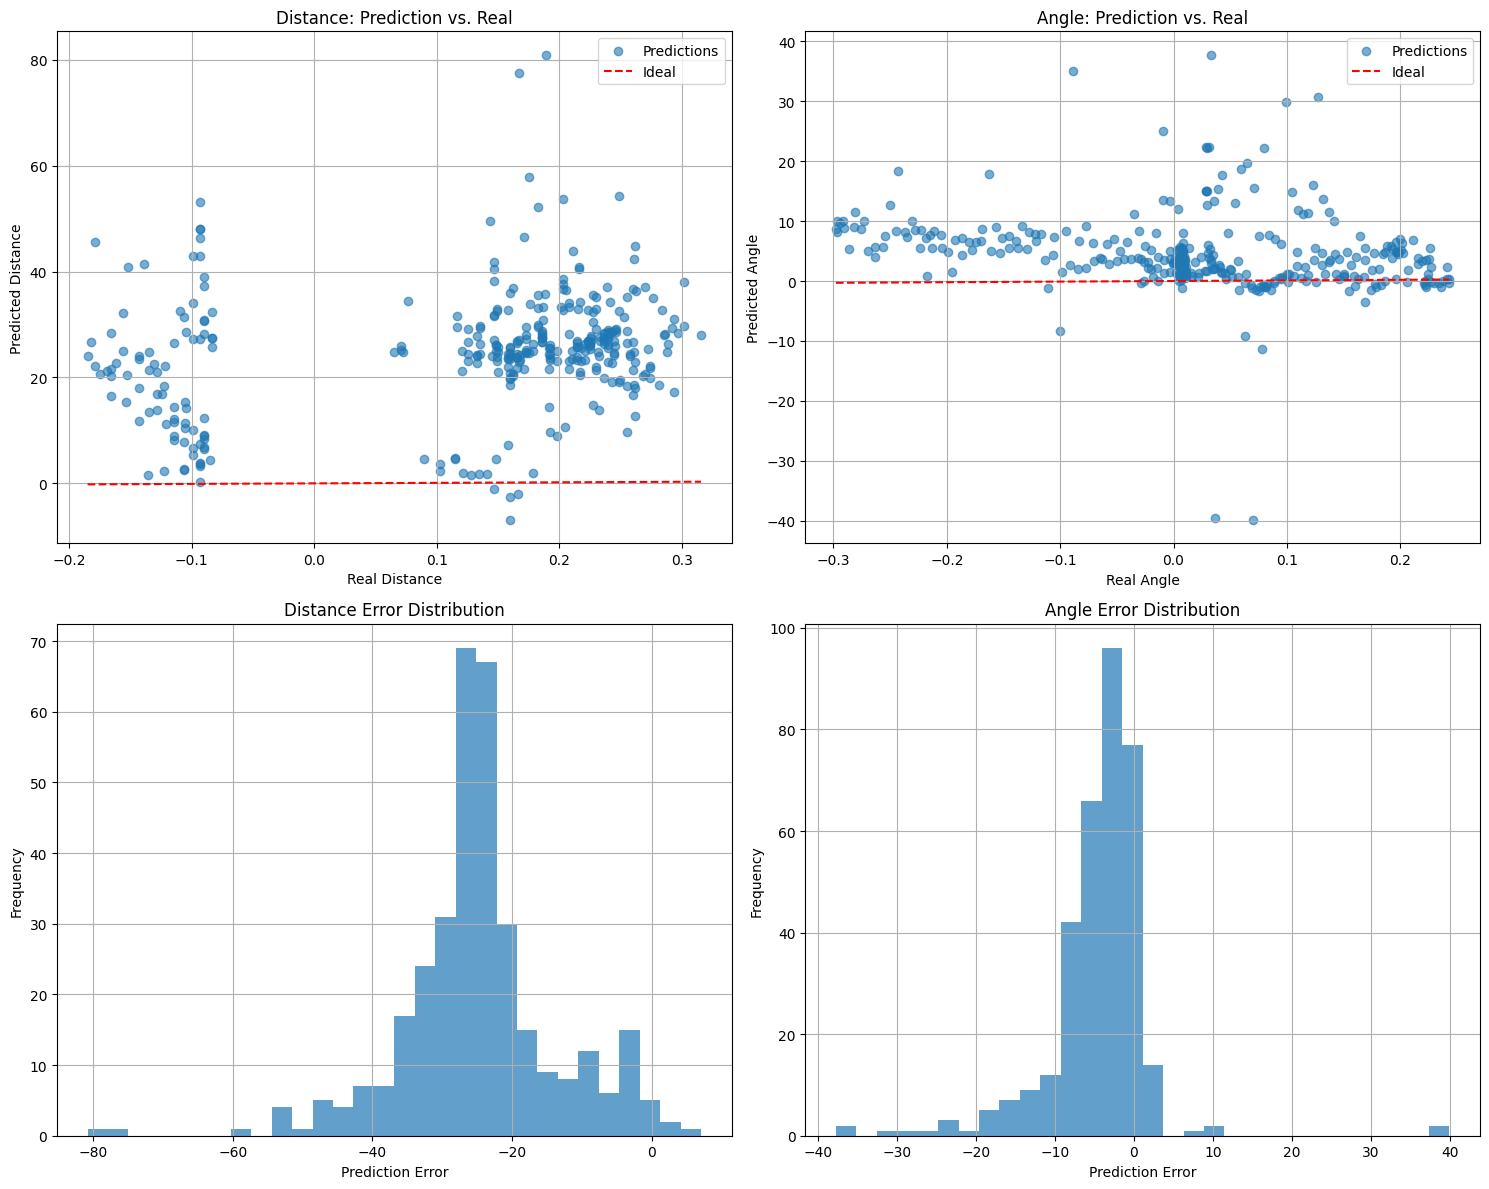

In [297]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
test_dataset = RobotDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)
model = LidarVisionFusionNet().to(device)
evaluate_model(model, test_loader)

In [ ]:
#sumarry the dataset


__len__ called. self.camera_images.shape: (1813, 40, 200, 3)
Distance - MSE: 525.6443, MAE: 20.6771
Angle - MSE: 109.9615, MAE: 6.5666

Plot saved to evaluation_results.png


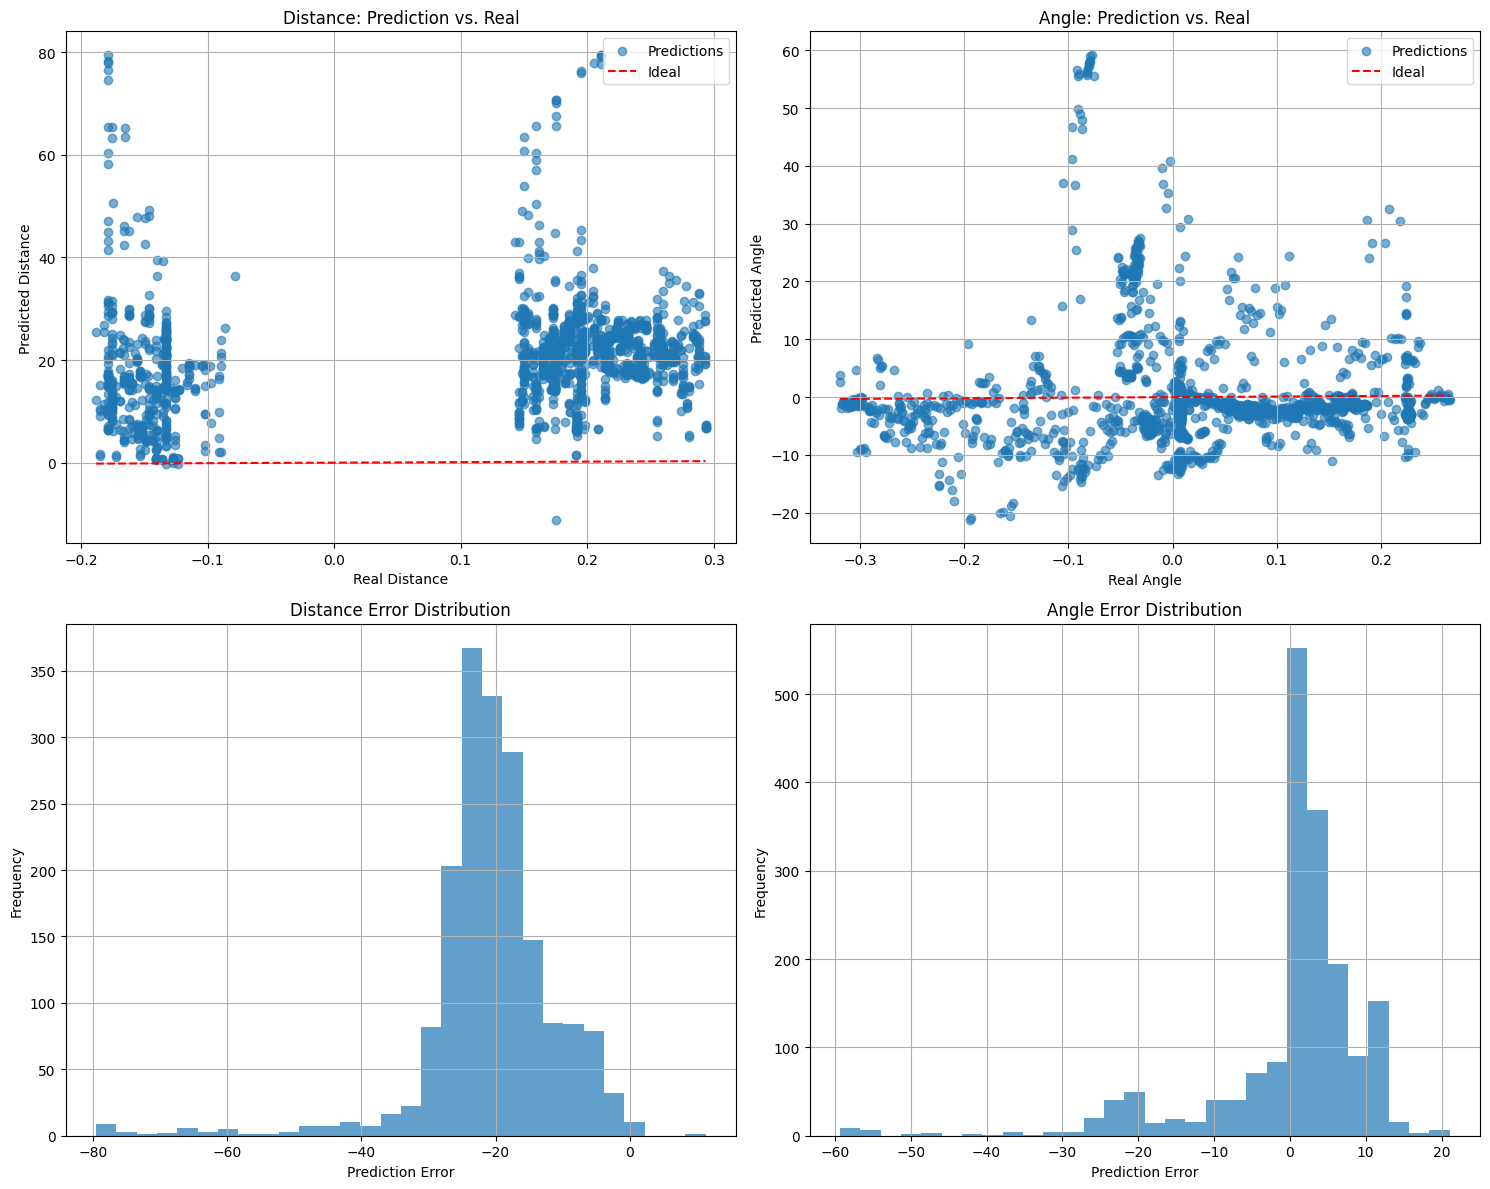

In [ ]:
dataset = RobotDataset(X, Y, transform=transform)
loader = DataLoader(dataset, batch_size=32)
model = LidarVisionFusionNet().to(device)
evaluate_model(model, loader)


In [11]:
# @title CNNNavigationModel
class CNNNavigationModel(nn.Module):
    """
    Define a arquitetura de um modelo CNN robusto para navegação usando dados de câmera e LiDAR.

    Este modelo aprimorado calcula dinamicamente o tamanho da entrada para as camadas
    totalmente conectadas, tornando-o robusto a mudanças nas dimensões da imagem de entrada
    ou na arquitetura da CNN. Ele também refatora a ramificação da câmera para maior clareza
    e inclui inicialização de pesos Kaiming.
    """
    def __init__(self, lidar_shape_in, img_shape=(IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)):
        """
        Inicializa o modelo CNN.

        Args:
            lidar_shape_in (int): O número de características de entrada para a ramificação LiDAR.
            img_shape (tuple): A forma da imagem de entrada (C, H, W).
        """
        super(CNNNavigationModel, self).__init__()

        # --- Ramificação da Câmera ---_
        # Definimos a parte convolucional primeiro para calcular dinamicamente seu tamanho de saída.
        camera_conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=img_shape[0], out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )

        # **MELHORIA 1: Cálculo dinâmico do tamanho das características**
        # Criamos um tensor "dummy" e o passamos pelas camadas convolucionais para descobrir o tamanho achatado.
        with torch.no_grad():
            dummy_input = torch.zeros(1, *img_shape)
            flattened_cam_size = camera_conv_layers(dummy_input).shape[1]


        # **MELHORIA 2: Clareza arquitetural**
        # Combinamos todo o pipeline de processamento da câmera em um único módulo sequencial.
        self.camera_branch = nn.Sequential(
            camera_conv_layers,
            nn.Linear(flattened_cam_size, 64),
            nn.ReLU()
        )

        # --- Ramificação do LiDAR ---_
        self.lidar_branch = nn.Sequential(
            nn.Linear(lidar_shape_in, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # --- Cabeça Combinada ---_
        # Esta parte permanece conceitualmente a mesma.
        self.combined_head = nn.Sequential(
            nn.Linear(64 + 64, 128),  # 64 da câmera + 64 do LiDAR
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),  # Saída de 2 valores (dist, angulo)
            nn.Tanh()          # Escala a saída para [-1, 1] para alvos normalizados
        )

        # **MELHORIA 3: Inicialização de Pesos**
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Aplica a inicialização Kaiming He às camadas Conv2d e Linear.
        """
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward(self, cam_input, lidar_input):
        """
        Define a passagem para a frente (forward pass) do modelo.

        Args:
            cam_input (torch.Tensor): O tensor de entrada da câmera.
                                      Forma: (N, C, H, W)
            lidar_input (torch.Tensor): O tensor de entrada do LiDAR.
                                        Forma: (N, lidar_shape_in)

        Returns:
            torch.Tensor: O tensor de saída do modelo. Forma: (N, 2)
        """
        cam_features = self.camera_branch(cam_input)
        lidar_features = self.lidar_branch(lidar_input)
        combined_features = torch.cat((cam_features, lidar_features), dim=1)
        output = self.combined_head(combined_features)
        return output

In [ ]:
# @title plot

def plot_history(history):
    """Plota o histórico de treinamento e validação e salva em um arquivo."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax2.plot(history['mae'], label='Training MAE')
    ax2.plot(history['val_mae'], label='Validation MAE')
    ax2.set_title('Model MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.tight_layout()
    plt.savefig(PLOT_SAVE_PATH)  # Salva a figura em um arquivo
    plt.close(fig)  # Fecha a figura para liberar memória
    print(f"Training plot saved to '{PLOT_SAVE_PATH}'")
    plt.close(fig)  # Fecha a figura para liberar memória

In [ ]:
(X_cam, X_lidar), y = load_data(DATASET_PATH)

Loading samples from '/content/drive/MyDrive/Colab Notebooks/cnn/merged_dataset.h5'...


In [ ]:
(X_cam_test, X_lidar_test), y_test = load_data(SCRIPT_DIR / "test.h5")  # /home/dino/Documents/ia/controllers/cnn/test.h5

Loading samples from '/content/drive/MyDrive/Colab Notebooks/cnn/test.h5'...


In [ ]:
# prompt: /content/drive/MyDrive/Colab Notebooks/cnn/checkpoints
# I want to delete all files in this folder
if False:
    import shutil

    # Define the directory to clean
    directory_to_clean = SCRIPT_DIR / 'checkpoints'

    # Check if the directory exists
    if directory_to_clean.exists() and directory_to_clean.is_dir():
        print(f"Cleaning directory: {directory_to_clean}")
        # Remove all files and subdirectories within the directory
        for item in directory_to_clean.iterdir():
            if item.is_file():
                item.unlink()  # Delete the file
                print(f"Deleted file: {item}")
            elif item.is_dir():
                shutil.rmtree(item) # Delete the subdirectory and its contents
                print(f"Deleted directory: {item}")
        print("Cleaning complete.")
    else:
        print(f"Directory not found or is not a directory: {directory_to_clean}")

Cleaning directory: /content/drive/MyDrive/Colab Notebooks/cnn/checkpoints
Cleaning complete.


In [ ]:
# @title train_cnn.py


if X_cam is None or X_cam.shape[0] == 0:
    print("Exiting: No data loaded.")
else:
    print(f"Data loaded. Shapes: Cam={X_cam.shape}, Lidar={X_lidar.shape}, Target={y.shape}")

    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    fold_histories = []

    best_overall_val_loss = float('inf')
    best_overall_checkpoint_path = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_cam)):
        print(f"\n--- Starting Fold {fold+1}/{N_SPLITS} ---")

        # Define o caminho do checkpoint para este fold específico
        checkpoint_path = CHECKPOINT_DIR / f'checkpoint_fold_{fold+1}.pth'

        # Split data for this fold
        X_cam_train, y_train = X_cam[train_idx], y[train_idx]
        X_lidar_train = X_lidar[train_idx]

        X_cam_val, y_val = X_cam[val_idx], y[val_idx]
        X_lidar_val = X_lidar[val_idx]

        # Converte dados para tensores PyTorch
        train_dataset = TensorDataset(torch.tensor(
            X_cam_train), torch.tensor(X_lidar_train), torch.tensor(y_train))
        train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        val_dataset = TensorDataset(torch.tensor(
            X_cam_val), torch.tensor(X_lidar_val), torch.tensor(y_val))
        val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Instancia o modelo e o otimizador
        model = CNNNavigationModel(lidar_shape_in=X_lidar.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Inicializa variáveis para o loop de treino e checkpoint
        start_epoch = 0
        best_val_loss = float('inf')
        history = {'loss': [], 'val_loss': [], 'mae': [],
                   'val_mae': [], "best_val_mae": 0.0}

        # --- Early Stopping parameters ---
        patience = 15  # Number of epochs to wait for improvement
        epochs_no_improve = 0
        min_delta = 0.002 # Minimum change to qualify as an improvement

        # --- LÓGICA PARA CARREGAR CHECKPOINT ---_
        if checkpoint_path.exists():
            print(f"Resuming training from checkpoint: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_loss = checkpoint['best_val_loss']
            history = checkpoint['history']
            # Reset early stopping counter if resuming
            epochs_no_improve = 0
            print(
                f"Resumed from epoch {start_epoch}. Best validation loss so far: {best_val_loss:.4f}")
        else:
            print(
                f"No checkpoint found for fold {fold+1}. Starting from scratch.")

        # Define as funções de perda
        criterion = nn.MSELoss()
        mae_criterion = nn.L1Loss()

        print(
            f"\n--- Starting Model Training for Fold {fold+1} from Epoch {start_epoch+1} ---")
        for epoch in range(start_epoch, EPOCHS):
            # --- Fase de Treinamento ---_
            model.train()
            running_loss, running_mae = 0.0, 0.0
            progress_bar = tqdm(
                train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{EPOCHS} [T]", leave=False)
            for cam_batch, lidar_batch, target_batch in progress_bar:
                cam_batch, lidar_batch, target_batch = cam_batch.to(
                    device), lidar_batch.to(device), target_batch.to(device)
                optimizer.zero_grad()
                outputs = model(cam_batch, lidar_batch)
                loss = criterion(outputs, target_batch)
                mae = mae_criterion(outputs, target_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                running_mae += mae.item()
                progress_bar.set_postfix(loss=loss.item(), mae=mae.item())

            epoch_loss = running_loss / len(train_loader)
            epoch_mae = running_mae / len(train_loader)
            history['loss'].append(epoch_loss)
            history['mae'].append(epoch_mae)

            # --- Fase de Validação ---_
            model.eval()
            val_loss, val_mae = 0.0, 0.0
            with torch.no_grad():
                for cam_batch, lidar_batch, target_batch in val_loader:
                    cam_batch, lidar_batch, target_batch = cam_batch.to(
                        device), lidar_batch.to(device), target_batch.to(device)
                    outputs = model(cam_batch, lidar_batch)
                    val_loss += criterion(outputs, target_batch).item()
                    val_mae += mae_criterion(outputs, target_batch).item()

            epoch_val_loss = val_loss / len(val_loader)
            epoch_val_mae = val_mae / len(val_loader)
            history['val_loss'].append(epoch_val_loss)
            history['val_mae'].append(epoch_val_mae)

            print(
                f"Fold {fold+1}/{N_SPLITS} Epoch {epoch+1}/{EPOCHS} - "
                f"Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f} - "
                f"Val Loss: {epoch_val_loss:.4f}, Val MAE: {epoch_val_mae:.4f}"
            )

            if epoch_val_loss < best_val_loss - min_delta:
                best_val_loss = epoch_val_loss
                epochs_no_improve = 0
                print(
                    f"  -> New best validation loss: {best_val_loss:.4f}. Saving checkpoint...")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'best_val_mae': epoch_val_mae,
                    'history': history
                }, checkpoint_path)

                history['best_val_mae'] = epoch_val_mae # Update best MAE when a new best loss is found
            else:
                epochs_no_improve += 1
                print(f"  -> Validation loss did not improve by at least {min_delta}. Epochs without improvement: {epochs_no_improve}")

            if epochs_no_improve == patience:
                print(f"  -> Early stopping triggered after {patience} epochs without improvement.")
                break # Exit the epoch loop


        # If training stopped due to early stopping, load the best model state for this fold
        if epochs_no_improve == patience and checkpoint_path.exists():
             print(f"  -> Loading best model state for fold {fold+1} after early stopping.")
             checkpoint = torch.load(checkpoint_path, map_location=device)
             model.load_state_dict(checkpoint['model_state_dict'])
             # Update history with the best validation MAE from the saved checkpoint
             history['best_val_mae'] = checkpoint['best_val_mae']


        fold_histories.append(history)

        # Update best overall checkpoint if this fold performed better
        if checkpoint_path.exists():
            checkpoint = torch.load(checkpoint_path, map_location=device)
            current_fold_best_val_loss = checkpoint['best_val_loss']
            if current_fold_best_val_loss < best_overall_val_loss:
                best_overall_val_loss = current_fold_best_val_loss
                best_overall_checkpoint_path = checkpoint_path

    # Agrega e plota os resultados de todos os folds
    if fold_histories:
        # Ensure all histories have the same length for averaging (due to early stopping)
        min_len = min(len(h['loss']) for h in fold_histories)
        for h in fold_histories:
            for key in h:
                if isinstance(h[key], list):
                    h[key] = h[key][:min_len]


        avg_history = {
            'loss': np.mean([h['loss'] for h in fold_histories], axis=0).tolist(),
            'val_loss': np.mean([h['val_loss'] for h in fold_histories], axis=0).tolist(),
            'mae': np.mean([h['mae'] for h in fold_histories], axis=0).tolist(),
            'val_mae': np.mean([h['val_mae'] for h in fold_histories], axis=0).tolist(),
            # best_val_mae is a single value per fold, so we average the last recorded best
            'best_val_mae': np.mean([h['best_val_mae'] for h in fold_histories]).tolist()
        }
        plot_history(avg_history)

    print("\nTraining complete.")

Data loaded. Shapes: Cam=(5891, 4, 40, 200), Lidar=(5891, 20), Target=(5891, 2)

--- Starting Fold 1/5 ---
Tamanho da característica da câmera achatada calculado dinamicamente: 24576
No checkpoint found for fold 1. Starting from scratch.

--- Starting Model Training for Fold 1 from Epoch 1 ---


Fold 1/5 Epoch 1/40 - Loss: 0.3279, MAE: 0.4756 - Val Loss: 0.0599, Val MAE: 0.1905
  -> New best validation loss: 0.0599. Saving checkpoint...


Fold 1/5 Epoch 2/40 - Loss: 0.1639, MAE: 0.3297 - Val Loss: 0.0625, Val MAE: 0.2031
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 1/5 Epoch 3/40 - Loss: 0.1230, MAE: 0.2832 - Val Loss: 0.0263, Val MAE: 0.1202
  -> New best validation loss: 0.0263. Saving checkpoint...


Fold 1/5 Epoch 4/40 - Loss: 0.0989, MAE: 0.2513 - Val Loss: 0.0297, Val MAE: 0.1356
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 1/5 Epoch 5/40 - Loss: 0.0793, MAE: 0.2225 - Val Loss: 0.0195, Val MAE: 0.0997
  -> New best validation loss: 0.0195. Saving checkpoint...


Fold 1/5 Epoch 6/40 - Loss: 0.0676, MAE: 0.2044 - Val Loss: 0.0174, Val MAE: 0.0945
  -> New best validation loss: 0.0174. Saving checkpoint...


Fold 1/5 Epoch 7/40 - Loss: 0.0570, MAE: 0.1869 - Val Loss: 0.0151, Val MAE: 0.0845
  -> New best validation loss: 0.0151. Saving checkpoint...


Fold 1/5 Epoch 8/40 - Loss: 0.0494, MAE: 0.1724 - Val Loss: 0.0134, Val MAE: 0.0770
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 1/5 Epoch 9/40 - Loss: 0.0438, MAE: 0.1618 - Val Loss: 0.0180, Val MAE: 0.1006
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 1/5 Epoch 10/40 - Loss: 0.0406, MAE: 0.1556 - Val Loss: 0.0141, Val MAE: 0.0776
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 1/5 Epoch 11/40 - Loss: 0.0356, MAE: 0.1457 - Val Loss: 0.0109, Val MAE: 0.0664
  -> New best validation loss: 0.0109. Saving checkpoint...


Fold 1/5 Epoch 12/40 - Loss: 0.0328, MAE: 0.1392 - Val Loss: 0.0117, Val MAE: 0.0677
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 1/5 Epoch 13/40 - Loss: 0.0309, MAE: 0.1347 - Val Loss: 0.0094, Val MAE: 0.0613
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 1/5 Epoch 14/40 - Loss: 0.0275, MAE: 0.1269 - Val Loss: 0.0089, Val MAE: 0.0606
  -> New best validation loss: 0.0089. Saving checkpoint...


Fold 1/5 Epoch 15/40 - Loss: 0.0265, MAE: 0.1238 - Val Loss: 0.0096, Val MAE: 0.0619
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 1/5 Epoch 16/40 - Loss: 0.0251, MAE: 0.1203 - Val Loss: 0.0089, Val MAE: 0.0641
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 1/5 Epoch 17/40 - Loss: 0.0236, MAE: 0.1164 - Val Loss: 0.0086, Val MAE: 0.0612
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 1/5 Epoch 18/40 - Loss: 0.0219, MAE: 0.1121 - Val Loss: 0.0095, Val MAE: 0.0674
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 1/5 Epoch 19/40 - Loss: 0.0215, MAE: 0.1108 - Val Loss: 0.0086, Val MAE: 0.0610
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 1/5 Epoch 20/40 - Loss: 0.0202, MAE: 0.1083 - Val Loss: 0.0087, Val MAE: 0.0619
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 1/5 Epoch 21/40 - Loss: 0.0197, MAE: 0.1055 - Val Loss: 0.0081, Val MAE: 0.0604
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 1/5 Epoch 22/40 - Loss: 0.0184, MAE: 0.1031 - Val Loss: 0.0074, Val MAE: 0.0561
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 1/5 Epoch 23/40 - Loss: 0.0179, MAE: 0.1017 - Val Loss: 0.0076, Val MAE: 0.0574
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 1/5 Epoch 24/40 - Loss: 0.0174, MAE: 0.0994 - Val Loss: 0.0075, Val MAE: 0.0560
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 1/5 Epoch 25/40 - Loss: 0.0163, MAE: 0.0961 - Val Loss: 0.0077, Val MAE: 0.0557
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 1/5 Epoch 26/40 - Loss: 0.0163, MAE: 0.0960 - Val Loss: 0.0082, Val MAE: 0.0580
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 12


Fold 1/5 Epoch 27/40 - Loss: 0.0157, MAE: 0.0944 - Val Loss: 0.0067, Val MAE: 0.0521
  -> New best validation loss: 0.0067. Saving checkpoint...


Fold 1/5 Epoch 28/40 - Loss: 0.0155, MAE: 0.0929 - Val Loss: 0.0069, Val MAE: 0.0533
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 1/5 Epoch 29/40 - Loss: 0.0145, MAE: 0.0905 - Val Loss: 0.0069, Val MAE: 0.0512
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 1/5 Epoch 30/40 - Loss: 0.0142, MAE: 0.0890 - Val Loss: 0.0067, Val MAE: 0.0517
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 1/5 Epoch 31/40 - Loss: 0.0136, MAE: 0.0872 - Val Loss: 0.0068, Val MAE: 0.0525
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 1/5 Epoch 32/40 - Loss: 0.0132, MAE: 0.0852 - Val Loss: 0.0066, Val MAE: 0.0497
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 1/5 Epoch 33/40 - Loss: 0.0130, MAE: 0.0844 - Val Loss: 0.0065, Val MAE: 0.0509
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 1/5 Epoch 34/40 - Loss: 0.0132, MAE: 0.0854 - Val Loss: 0.0062, Val MAE: 0.0488
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 1/5 Epoch 35/40 - Loss: 0.0135, MAE: 0.0862 - Val Loss: 0.0062, Val MAE: 0.0483
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 1/5 Epoch 36/40 - Loss: 0.0119, MAE: 0.0808 - Val Loss: 0.0060, Val MAE: 0.0478
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 1/5 Epoch 37/40 - Loss: 0.0116, MAE: 0.0794 - Val Loss: 0.0059, Val MAE: 0.0484
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 1/5 Epoch 38/40 - Loss: 0.0115, MAE: 0.0796 - Val Loss: 0.0060, Val MAE: 0.0468
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 1/5 Epoch 39/40 - Loss: 0.0113, MAE: 0.0785 - Val Loss: 0.0056, Val MAE: 0.0449
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 12


Fold 1/5 Epoch 40/40 - Loss: 0.0112, MAE: 0.0787 - Val Loss: 0.0063, Val MAE: 0.0521
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 13

--- Starting Fold 2/5 ---
Tamanho da característica da câmera achatada calculado dinamicamente: 24576
No checkpoint found for fold 2. Starting from scratch.

--- Starting Model Training for Fold 2 from Epoch 1 ---


Fold 2/5 Epoch 1/40 - Loss: 0.1856, MAE: 0.3490 - Val Loss: 0.0425, Val MAE: 0.1647
  -> New best validation loss: 0.0425. Saving checkpoint...


Fold 2/5 Epoch 2/40 - Loss: 0.1149, MAE: 0.2687 - Val Loss: 0.0308, Val MAE: 0.1334
  -> New best validation loss: 0.0308. Saving checkpoint...


Fold 2/5 Epoch 3/40 - Loss: 0.0837, MAE: 0.2264 - Val Loss: 0.0256, Val MAE: 0.1261
  -> New best validation loss: 0.0256. Saving checkpoint...


Fold 2/5 Epoch 4/40 - Loss: 0.0690, MAE: 0.2051 - Val Loss: 0.0254, Val MAE: 0.1237
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 2/5 Epoch 5/40 - Loss: 0.0553, MAE: 0.1819 - Val Loss: 0.0207, Val MAE: 0.1102
  -> New best validation loss: 0.0207. Saving checkpoint...


Fold 2/5 Epoch 6/40 - Loss: 0.0478, MAE: 0.1681 - Val Loss: 0.0168, Val MAE: 0.0957
  -> New best validation loss: 0.0168. Saving checkpoint...


Fold 2/5 Epoch 7/40 - Loss: 0.0423, MAE: 0.1579 - Val Loss: 0.0140, Val MAE: 0.0907
  -> New best validation loss: 0.0140. Saving checkpoint...


Fold 2/5 Epoch 8/40 - Loss: 0.0364, MAE: 0.1465 - Val Loss: 0.0113, Val MAE: 0.0762
  -> New best validation loss: 0.0113. Saving checkpoint...


Fold 2/5 Epoch 9/40 - Loss: 0.0326, MAE: 0.1370 - Val Loss: 0.0119, Val MAE: 0.0838
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 2/5 Epoch 10/40 - Loss: 0.0289, MAE: 0.1290 - Val Loss: 0.0101, Val MAE: 0.0718
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 2/5 Epoch 11/40 - Loss: 0.0268, MAE: 0.1238 - Val Loss: 0.0096, Val MAE: 0.0685
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 2/5 Epoch 12/40 - Loss: 0.0252, MAE: 0.1196 - Val Loss: 0.0090, Val MAE: 0.0664
  -> New best validation loss: 0.0090. Saving checkpoint...


Fold 2/5 Epoch 13/40 - Loss: 0.0226, MAE: 0.1124 - Val Loss: 0.0096, Val MAE: 0.0684
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 2/5 Epoch 14/40 - Loss: 0.0216, MAE: 0.1103 - Val Loss: 0.0080, Val MAE: 0.0620
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 2/5 Epoch 15/40 - Loss: 0.0202, MAE: 0.1059 - Val Loss: 0.0074, Val MAE: 0.0576
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 2/5 Epoch 16/40 - Loss: 0.0194, MAE: 0.1036 - Val Loss: 0.0085, Val MAE: 0.0637
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 2/5 Epoch 17/40 - Loss: 0.0178, MAE: 0.0999 - Val Loss: 0.0078, Val MAE: 0.0596
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 2/5 Epoch 18/40 - Loss: 0.0175, MAE: 0.0982 - Val Loss: 0.0072, Val MAE: 0.0567
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 2/5 Epoch 19/40 - Loss: 0.0164, MAE: 0.0948 - Val Loss: 0.0072, Val MAE: 0.0557
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 2/5 Epoch 20/40 - Loss: 0.0161, MAE: 0.0937 - Val Loss: 0.0074, Val MAE: 0.0586
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 2/5 Epoch 21/40 - Loss: 0.0156, MAE: 0.0921 - Val Loss: 0.0071, Val MAE: 0.0559
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 2/5 Epoch 22/40 - Loss: 0.0147, MAE: 0.0887 - Val Loss: 0.0073, Val MAE: 0.0570
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 2/5 Epoch 23/40 - Loss: 0.0138, MAE: 0.0863 - Val Loss: 0.0063, Val MAE: 0.0515
  -> New best validation loss: 0.0063. Saving checkpoint...


Fold 2/5 Epoch 24/40 - Loss: 0.0137, MAE: 0.0854 - Val Loss: 0.0061, Val MAE: 0.0509
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 2/5 Epoch 25/40 - Loss: 0.0136, MAE: 0.0852 - Val Loss: 0.0063, Val MAE: 0.0522
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 2/5 Epoch 26/40 - Loss: 0.0130, MAE: 0.0834 - Val Loss: 0.0064, Val MAE: 0.0526
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 2/5 Epoch 27/40 - Loss: 0.0122, MAE: 0.0814 - Val Loss: 0.0071, Val MAE: 0.0592
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 2/5 Epoch 28/40 - Loss: 0.0120, MAE: 0.0798 - Val Loss: 0.0064, Val MAE: 0.0523
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 2/5 Epoch 29/40 - Loss: 0.0118, MAE: 0.0795 - Val Loss: 0.0060, Val MAE: 0.0494
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 2/5 Epoch 30/40 - Loss: 0.0115, MAE: 0.0781 - Val Loss: 0.0056, Val MAE: 0.0485
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 2/5 Epoch 31/40 - Loss: 0.0111, MAE: 0.0770 - Val Loss: 0.0058, Val MAE: 0.0496
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 2/5 Epoch 32/40 - Loss: 0.0110, MAE: 0.0764 - Val Loss: 0.0063, Val MAE: 0.0534
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 2/5 Epoch 33/40 - Loss: 0.0104, MAE: 0.0748 - Val Loss: 0.0064, Val MAE: 0.0548
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 2/5 Epoch 34/40 - Loss: 0.0104, MAE: 0.0740 - Val Loss: 0.0057, Val MAE: 0.0506
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 2/5 Epoch 35/40 - Loss: 0.0101, MAE: 0.0731 - Val Loss: 0.0058, Val MAE: 0.0508
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 12


Fold 2/5 Epoch 36/40 - Loss: 0.0099, MAE: 0.0729 - Val Loss: 0.0060, Val MAE: 0.0530
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 13


Fold 2/5 Epoch 37/40 - Loss: 0.0095, MAE: 0.0717 - Val Loss: 0.0055, Val MAE: 0.0490
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 14


Fold 2/5 Epoch 38/40 - Loss: 0.0091, MAE: 0.0693 - Val Loss: 0.0058, Val MAE: 0.0504
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 15
  -> Early stopping triggered after 15 epochs without improvement.
  -> Loading best model state for fold 2 after early stopping.

--- Starting Fold 3/5 ---
Tamanho da característica da câmera achatada calculado dinamicamente: 24576
No checkpoint found for fold 3. Starting from scratch.

--- Starting Model Training for Fold 3 from Epoch 1 ---


Fold 3/5 Epoch 1/40 - Loss: 0.2178, MAE: 0.3759 - Val Loss: 0.0452, Val MAE: 0.1575
  -> New best validation loss: 0.0452. Saving checkpoint...


Fold 3/5 Epoch 2/40 - Loss: 0.0854, MAE: 0.2300 - Val Loss: 0.0348, Val MAE: 0.1315
  -> New best validation loss: 0.0348. Saving checkpoint...


Fold 3/5 Epoch 3/40 - Loss: 0.0628, MAE: 0.1943 - Val Loss: 0.0296, Val MAE: 0.1137
  -> New best validation loss: 0.0296. Saving checkpoint...


Fold 3/5 Epoch 4/40 - Loss: 0.0537, MAE: 0.1789 - Val Loss: 0.0247, Val MAE: 0.1040
  -> New best validation loss: 0.0247. Saving checkpoint...


Fold 3/5 Epoch 5/40 - Loss: 0.0464, MAE: 0.1643 - Val Loss: 0.0220, Val MAE: 0.0951
  -> New best validation loss: 0.0220. Saving checkpoint...


Fold 3/5 Epoch 6/40 - Loss: 0.0393, MAE: 0.1520 - Val Loss: 0.0189, Val MAE: 0.0861
  -> New best validation loss: 0.0189. Saving checkpoint...


Fold 3/5 Epoch 7/40 - Loss: 0.0345, MAE: 0.1423 - Val Loss: 0.0181, Val MAE: 0.0867
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 3/5 Epoch 8/40 - Loss: 0.0318, MAE: 0.1357 - Val Loss: 0.0174, Val MAE: 0.0828
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 3/5 Epoch 9/40 - Loss: 0.0286, MAE: 0.1286 - Val Loss: 0.0149, Val MAE: 0.0778
  -> New best validation loss: 0.0149. Saving checkpoint...


Fold 3/5 Epoch 10/40 - Loss: 0.0275, MAE: 0.1256 - Val Loss: 0.0131, Val MAE: 0.0724
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 3/5 Epoch 11/40 - Loss: 0.0249, MAE: 0.1202 - Val Loss: 0.0141, Val MAE: 0.0794
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 3/5 Epoch 12/40 - Loss: 0.0231, MAE: 0.1148 - Val Loss: 0.0134, Val MAE: 0.0783
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 3/5 Epoch 13/40 - Loss: 0.0222, MAE: 0.1116 - Val Loss: 0.0150, Val MAE: 0.0871
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 3/5 Epoch 14/40 - Loss: 0.0214, MAE: 0.1105 - Val Loss: 0.0118, Val MAE: 0.0687
  -> New best validation loss: 0.0118. Saving checkpoint...


Fold 3/5 Epoch 15/40 - Loss: 0.0194, MAE: 0.1038 - Val Loss: 0.0111, Val MAE: 0.0638
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 3/5 Epoch 16/40 - Loss: 0.0180, MAE: 0.1006 - Val Loss: 0.0105, Val MAE: 0.0629
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 3/5 Epoch 17/40 - Loss: 0.0179, MAE: 0.0998 - Val Loss: 0.0109, Val MAE: 0.0662
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 3/5 Epoch 18/40 - Loss: 0.0170, MAE: 0.0971 - Val Loss: 0.0104, Val MAE: 0.0625
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 3/5 Epoch 19/40 - Loss: 0.0168, MAE: 0.0970 - Val Loss: 0.0097, Val MAE: 0.0605
  -> New best validation loss: 0.0097. Saving checkpoint...


Fold 3/5 Epoch 20/40 - Loss: 0.0158, MAE: 0.0927 - Val Loss: 0.0097, Val MAE: 0.0622
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 3/5 Epoch 21/40 - Loss: 0.0154, MAE: 0.0925 - Val Loss: 0.0095, Val MAE: 0.0605
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 3/5 Epoch 22/40 - Loss: 0.0156, MAE: 0.0924 - Val Loss: 0.0090, Val MAE: 0.0572
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 3/5 Epoch 23/40 - Loss: 0.0145, MAE: 0.0886 - Val Loss: 0.0103, Val MAE: 0.0689
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 3/5 Epoch 24/40 - Loss: 0.0142, MAE: 0.0885 - Val Loss: 0.0083, Val MAE: 0.0553
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 3/5 Epoch 25/40 - Loss: 0.0141, MAE: 0.0880 - Val Loss: 0.0095, Val MAE: 0.0655
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 3/5 Epoch 26/40 - Loss: 0.0133, MAE: 0.0842 - Val Loss: 0.0086, Val MAE: 0.0610
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 3/5 Epoch 27/40 - Loss: 0.0129, MAE: 0.0828 - Val Loss: 0.0081, Val MAE: 0.0552
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 3/5 Epoch 28/40 - Loss: 0.0129, MAE: 0.0832 - Val Loss: 0.0083, Val MAE: 0.0596
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 3/5 Epoch 29/40 - Loss: 0.0126, MAE: 0.0824 - Val Loss: 0.0082, Val MAE: 0.0608
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 3/5 Epoch 30/40 - Loss: 0.0120, MAE: 0.0808 - Val Loss: 0.0081, Val MAE: 0.0594
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 3/5 Epoch 31/40 - Loss: 0.0121, MAE: 0.0804 - Val Loss: 0.0075, Val MAE: 0.0552
  -> New best validation loss: 0.0075. Saving checkpoint...


Fold 3/5 Epoch 32/40 - Loss: 0.0115, MAE: 0.0782 - Val Loss: 0.0077, Val MAE: 0.0561
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 3/5 Epoch 33/40 - Loss: 0.0112, MAE: 0.0776 - Val Loss: 0.0077, Val MAE: 0.0574
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 3/5 Epoch 34/40 - Loss: 0.0109, MAE: 0.0762 - Val Loss: 0.0076, Val MAE: 0.0567
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 3/5 Epoch 35/40 - Loss: 0.0110, MAE: 0.0768 - Val Loss: 0.0075, Val MAE: 0.0564
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 3/5 Epoch 36/40 - Loss: 0.0107, MAE: 0.0750 - Val Loss: 0.0072, Val MAE: 0.0548
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 3/5 Epoch 37/40 - Loss: 0.0105, MAE: 0.0749 - Val Loss: 0.0068, Val MAE: 0.0506
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 3/5 Epoch 38/40 - Loss: 0.0104, MAE: 0.0740 - Val Loss: 0.0069, Val MAE: 0.0539
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 3/5 Epoch 39/40 - Loss: 0.0108, MAE: 0.0761 - Val Loss: 0.0075, Val MAE: 0.0591
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 3/5 Epoch 40/40 - Loss: 0.0098, MAE: 0.0717 - Val Loss: 0.0067, Val MAE: 0.0545
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9

--- Starting Fold 4/5 ---
Tamanho da característica da câmera achatada calculado dinamicamente: 24576
No checkpoint found for fold 4. Starting from scratch.

--- Starting Model Training for Fold 4 from Epoch 1 ---


Fold 4/5 Epoch 1/40 - Loss: 0.1931, MAE: 0.3533 - Val Loss: 0.0557, Val MAE: 0.1929
  -> New best validation loss: 0.0557. Saving checkpoint...


Fold 4/5 Epoch 2/40 - Loss: 0.0946, MAE: 0.2428 - Val Loss: 0.0587, Val MAE: 0.2039
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 4/5 Epoch 3/40 - Loss: 0.0673, MAE: 0.2037 - Val Loss: 0.0532, Val MAE: 0.1903
  -> New best validation loss: 0.0532. Saving checkpoint...


Fold 4/5 Epoch 4/40 - Loss: 0.0579, MAE: 0.1861 - Val Loss: 0.0280, Val MAE: 0.1343
  -> New best validation loss: 0.0280. Saving checkpoint...


Fold 4/5 Epoch 5/40 - Loss: 0.0489, MAE: 0.1712 - Val Loss: 0.0273, Val MAE: 0.1319
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 4/5 Epoch 6/40 - Loss: 0.0431, MAE: 0.1592 - Val Loss: 0.0212, Val MAE: 0.1126
  -> New best validation loss: 0.0212. Saving checkpoint...


Fold 4/5 Epoch 7/40 - Loss: 0.0379, MAE: 0.1480 - Val Loss: 0.0214, Val MAE: 0.1179
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 4/5 Epoch 8/40 - Loss: 0.0333, MAE: 0.1389 - Val Loss: 0.0197, Val MAE: 0.1127
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 4/5 Epoch 9/40 - Loss: 0.0308, MAE: 0.1334 - Val Loss: 0.0152, Val MAE: 0.0922
  -> New best validation loss: 0.0152. Saving checkpoint...


Fold 4/5 Epoch 10/40 - Loss: 0.0289, MAE: 0.1280 - Val Loss: 0.0137, Val MAE: 0.0845
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 4/5 Epoch 11/40 - Loss: 0.0257, MAE: 0.1211 - Val Loss: 0.0150, Val MAE: 0.0955
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 4/5 Epoch 12/40 - Loss: 0.0238, MAE: 0.1159 - Val Loss: 0.0149, Val MAE: 0.0972
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 4/5 Epoch 13/40 - Loss: 0.0223, MAE: 0.1123 - Val Loss: 0.0145, Val MAE: 0.0953
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 4/5 Epoch 14/40 - Loss: 0.0204, MAE: 0.1066 - Val Loss: 0.0108, Val MAE: 0.0751
  -> New best validation loss: 0.0108. Saving checkpoint...


Fold 4/5 Epoch 15/40 - Loss: 0.0193, MAE: 0.1057 - Val Loss: 0.0134, Val MAE: 0.0938
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 4/5 Epoch 16/40 - Loss: 0.0181, MAE: 0.1019 - Val Loss: 0.0112, Val MAE: 0.0802
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 4/5 Epoch 17/40 - Loss: 0.0175, MAE: 0.0983 - Val Loss: 0.0114, Val MAE: 0.0849
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 4/5 Epoch 18/40 - Loss: 0.0160, MAE: 0.0953 - Val Loss: 0.0103, Val MAE: 0.0788
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 4/5 Epoch 19/40 - Loss: 0.0160, MAE: 0.0944 - Val Loss: 0.0108, Val MAE: 0.0824
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 4/5 Epoch 20/40 - Loss: 0.0148, MAE: 0.0922 - Val Loss: 0.0099, Val MAE: 0.0797
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 4/5 Epoch 21/40 - Loss: 0.0138, MAE: 0.0882 - Val Loss: 0.0099, Val MAE: 0.0791
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 4/5 Epoch 22/40 - Loss: 0.0134, MAE: 0.0864 - Val Loss: 0.0095, Val MAE: 0.0774
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 4/5 Epoch 23/40 - Loss: 0.0129, MAE: 0.0843 - Val Loss: 0.0090, Val MAE: 0.0755
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 4/5 Epoch 24/40 - Loss: 0.0128, MAE: 0.0850 - Val Loss: 0.0080, Val MAE: 0.0677
  -> New best validation loss: 0.0080. Saving checkpoint...


Fold 4/5 Epoch 25/40 - Loss: 0.0123, MAE: 0.0827 - Val Loss: 0.0081, Val MAE: 0.0692
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 4/5 Epoch 26/40 - Loss: 0.0119, MAE: 0.0818 - Val Loss: 0.0073, Val MAE: 0.0631
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 4/5 Epoch 27/40 - Loss: 0.0115, MAE: 0.0799 - Val Loss: 0.0081, Val MAE: 0.0684
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 4/5 Epoch 28/40 - Loss: 0.0116, MAE: 0.0804 - Val Loss: 0.0084, Val MAE: 0.0726
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 4/5 Epoch 29/40 - Loss: 0.0112, MAE: 0.0786 - Val Loss: 0.0079, Val MAE: 0.0680
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 4/5 Epoch 30/40 - Loss: 0.0108, MAE: 0.0779 - Val Loss: 0.0080, Val MAE: 0.0700
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 4/5 Epoch 31/40 - Loss: 0.0105, MAE: 0.0766 - Val Loss: 0.0068, Val MAE: 0.0603
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 4/5 Epoch 32/40 - Loss: 0.0101, MAE: 0.0750 - Val Loss: 0.0077, Val MAE: 0.0653
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 4/5 Epoch 33/40 - Loss: 0.0100, MAE: 0.0737 - Val Loss: 0.0065, Val MAE: 0.0591
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 4/5 Epoch 34/40 - Loss: 0.0096, MAE: 0.0720 - Val Loss: 0.0073, Val MAE: 0.0637
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 4/5 Epoch 35/40 - Loss: 0.0097, MAE: 0.0722 - Val Loss: 0.0072, Val MAE: 0.0646
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 4/5 Epoch 36/40 - Loss: 0.0093, MAE: 0.0714 - Val Loss: 0.0066, Val MAE: 0.0594
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 12


Fold 4/5 Epoch 37/40 - Loss: 0.0092, MAE: 0.0710 - Val Loss: 0.0066, Val MAE: 0.0598
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 13


Fold 4/5 Epoch 38/40 - Loss: 0.0088, MAE: 0.0694 - Val Loss: 0.0067, Val MAE: 0.0605
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 14


Fold 4/5 Epoch 39/40 - Loss: 0.0089, MAE: 0.0690 - Val Loss: 0.0066, Val MAE: 0.0607
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 15
  -> Early stopping triggered after 15 epochs without improvement.
  -> Loading best model state for fold 4 after early stopping.

--- Starting Fold 5/5 ---
Tamanho da característica da câmera achatada calculado dinamicamente: 24576
No checkpoint found for fold 5. Starting from scratch.

--- Starting Model Training for Fold 5 from Epoch 1 ---


Fold 5/5 Epoch 1/40 - Loss: 0.2004, MAE: 0.3571 - Val Loss: 0.0507, Val MAE: 0.1682
  -> New best validation loss: 0.0507. Saving checkpoint...


Fold 5/5 Epoch 2/40 - Loss: 0.0862, MAE: 0.2283 - Val Loss: 0.0431, Val MAE: 0.1593
  -> New best validation loss: 0.0431. Saving checkpoint...


Fold 5/5 Epoch 3/40 - Loss: 0.0683, MAE: 0.2013 - Val Loss: 0.0299, Val MAE: 0.1283
  -> New best validation loss: 0.0299. Saving checkpoint...


Fold 5/5 Epoch 4/40 - Loss: 0.0558, MAE: 0.1789 - Val Loss: 0.0229, Val MAE: 0.1076
  -> New best validation loss: 0.0229. Saving checkpoint...


Fold 5/5 Epoch 5/40 - Loss: 0.0490, MAE: 0.1682 - Val Loss: 0.0196, Val MAE: 0.0980
  -> New best validation loss: 0.0196. Saving checkpoint...


Fold 5/5 Epoch 6/40 - Loss: 0.0420, MAE: 0.1550 - Val Loss: 0.0175, Val MAE: 0.0965
  -> New best validation loss: 0.0175. Saving checkpoint...


Fold 5/5 Epoch 7/40 - Loss: 0.0368, MAE: 0.1449 - Val Loss: 0.0142, Val MAE: 0.0864
  -> New best validation loss: 0.0142. Saving checkpoint...


Fold 5/5 Epoch 8/40 - Loss: 0.0333, MAE: 0.1394 - Val Loss: 0.0130, Val MAE: 0.0841
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 5/5 Epoch 9/40 - Loss: 0.0297, MAE: 0.1303 - Val Loss: 0.0123, Val MAE: 0.0804
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 5/5 Epoch 10/40 - Loss: 0.0278, MAE: 0.1270 - Val Loss: 0.0105, Val MAE: 0.0724
  -> New best validation loss: 0.0105. Saving checkpoint...


Fold 5/5 Epoch 11/40 - Loss: 0.0256, MAE: 0.1216 - Val Loss: 0.0110, Val MAE: 0.0759
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 5/5 Epoch 12/40 - Loss: 0.0241, MAE: 0.1171 - Val Loss: 0.0088, Val MAE: 0.0653
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 5/5 Epoch 13/40 - Loss: 0.0226, MAE: 0.1138 - Val Loss: 0.0084, Val MAE: 0.0634
  -> New best validation loss: 0.0084. Saving checkpoint...


Fold 5/5 Epoch 14/40 - Loss: 0.0213, MAE: 0.1116 - Val Loss: 0.0124, Val MAE: 0.0896
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 5/5 Epoch 15/40 - Loss: 0.0207, MAE: 0.1089 - Val Loss: 0.0085, Val MAE: 0.0659
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 5/5 Epoch 16/40 - Loss: 0.0197, MAE: 0.1060 - Val Loss: 0.0088, Val MAE: 0.0679
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 5/5 Epoch 17/40 - Loss: 0.0182, MAE: 0.1017 - Val Loss: 0.0087, Val MAE: 0.0670
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 5/5 Epoch 18/40 - Loss: 0.0184, MAE: 0.1034 - Val Loss: 0.0081, Val MAE: 0.0639
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 5/5 Epoch 19/40 - Loss: 0.0170, MAE: 0.0997 - Val Loss: 0.0086, Val MAE: 0.0660
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 5/5 Epoch 20/40 - Loss: 0.0160, MAE: 0.0958 - Val Loss: 0.0078, Val MAE: 0.0645
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 5/5 Epoch 21/40 - Loss: 0.0161, MAE: 0.0957 - Val Loss: 0.0081, Val MAE: 0.0645
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 5/5 Epoch 22/40 - Loss: 0.0150, MAE: 0.0919 - Val Loss: 0.0077, Val MAE: 0.0637
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 5/5 Epoch 23/40 - Loss: 0.0147, MAE: 0.0911 - Val Loss: 0.0080, Val MAE: 0.0657
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 5/5 Epoch 24/40 - Loss: 0.0141, MAE: 0.0898 - Val Loss: 0.0076, Val MAE: 0.0619
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 5/5 Epoch 25/40 - Loss: 0.0134, MAE: 0.0871 - Val Loss: 0.0068, Val MAE: 0.0561
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 12


Fold 5/5 Epoch 26/40 - Loss: 0.0131, MAE: 0.0856 - Val Loss: 0.0067, Val MAE: 0.0569
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 13


Fold 5/5 Epoch 27/40 - Loss: 0.0130, MAE: 0.0854 - Val Loss: 0.0064, Val MAE: 0.0542
  -> New best validation loss: 0.0064. Saving checkpoint...


Fold 5/5 Epoch 28/40 - Loss: 0.0127, MAE: 0.0841 - Val Loss: 0.0074, Val MAE: 0.0624
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 1


Fold 5/5 Epoch 29/40 - Loss: 0.0125, MAE: 0.0844 - Val Loss: 0.0065, Val MAE: 0.0553
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 2


Fold 5/5 Epoch 30/40 - Loss: 0.0123, MAE: 0.0831 - Val Loss: 0.0068, Val MAE: 0.0584
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 3


Fold 5/5 Epoch 31/40 - Loss: 0.0117, MAE: 0.0812 - Val Loss: 0.0063, Val MAE: 0.0541
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 4


Fold 5/5 Epoch 32/40 - Loss: 0.0112, MAE: 0.0790 - Val Loss: 0.0061, Val MAE: 0.0524
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 5


Fold 5/5 Epoch 33/40 - Loss: 0.0111, MAE: 0.0786 - Val Loss: 0.0060, Val MAE: 0.0529
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 6


Fold 5/5 Epoch 34/40 - Loss: 0.0108, MAE: 0.0782 - Val Loss: 0.0071, Val MAE: 0.0606
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 7


Fold 5/5 Epoch 35/40 - Loss: 0.0108, MAE: 0.0780 - Val Loss: 0.0064, Val MAE: 0.0566
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 8


Fold 5/5 Epoch 36/40 - Loss: 0.0108, MAE: 0.0773 - Val Loss: 0.0058, Val MAE: 0.0497
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 9


Fold 5/5 Epoch 37/40 - Loss: 0.0104, MAE: 0.0759 - Val Loss: 0.0057, Val MAE: 0.0492
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 10


Fold 5/5 Epoch 38/40 - Loss: 0.0102, MAE: 0.0743 - Val Loss: 0.0058, Val MAE: 0.0511
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 11


Fold 5/5 Epoch 39/40 - Loss: 0.0099, MAE: 0.0738 - Val Loss: 0.0060, Val MAE: 0.0533
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 12


Fold 5/5 Epoch 40/40 - Loss: 0.0098, MAE: 0.0734 - Val Loss: 0.0058, Val MAE: 0.0501
  -> Validation loss did not improve by at least 0.002. Epochs without improvement: 13
Training plot saved to '/content/drive/MyDrive/Colab Notebooks/cnn/training_history.png'

Training complete.


In [ ]:
final_model_path = SCRIPT_DIR / 'final_cnn_model.pth'


In [ ]:
def fine_tune_model(best_checkpoint_path: Path, full_dataset_path: Path, fine_tune_epochs: int = 2, fine_tune_lr: float = 1e-3):
    print(f"\n--- Starting Fine-tuning on Entire Dataset ---")
    print(f"Loading best model from: {best_checkpoint_path}")

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the full dataset
    (X_cam, X_lidar), y = load_data(full_dataset_path)
    if X_cam is None or X_cam.shape[0] == 0:
        print("Exiting fine-tuning: No data loaded for full dataset.")
        return

    print(
        f"Full dataset loaded. Shapes: Cam={X_cam.shape}, Lidar={X_lidar.shape}, Target={y.shape}")

    # Create DataLoader for the full dataset
    full_dataset = TensorDataset(torch.tensor(
        X_cam), torch.tensor(X_lidar), torch.tensor(y))
    full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Instantiate model and load state dict
    model = CNNNavigationModel(lidar_shape_in=X_lidar.shape[1]).to(device)
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Optimizer for fine-tuning (can be a new one with lower LR)
    optimizer = optim.Adam(model.parameters(), lr=fine_tune_lr)
    # Optionally load optimizer state if resuming fine-tuning
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    print(f"Fine-tuning for {fine_tune_epochs} epochs with LR: {fine_tune_lr}")

    model.train()  # Set model to training mode
    for epoch in range(fine_tune_epochs):
        running_loss, running_mae = 0.0, 0.0
        progress_bar = tqdm(
            full_loader, desc=f"Fine-tune Epoch {epoch+1}/{fine_tune_epochs}", leave=False)
        for cam_batch, lidar_batch, target_batch in progress_bar:
            cam_batch, lidar_batch, target_batch = cam_batch.to(
                device), lidar_batch.to(device), target_batch.to(device)
            optimizer.zero_grad()
            outputs = model(cam_batch, lidar_batch)
            loss = criterion(outputs, target_batch)
            mae = mae_criterion(outputs, target_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_mae += mae.item()
            progress_bar.set_postfix(loss=loss.item(), mae=mae.item())

        epoch_loss = running_loss / len(full_loader)
        epoch_mae = running_mae / len(full_loader)
        print(
            f"Fine-tune Epoch {epoch+1}/{fine_tune_epochs} - Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f}")

    # Save the final fine-tuned model
    torch.save(model.state_dict(), FINAL_MODEL_PATH)
    print(f"Fine-tuned model saved to: {FINAL_MODEL_PATH}")
best_overall_checkpoint_path = True
if best_overall_checkpoint_path:
    fine_tune_model(Path("/content/drive/MyDrive/Colab Notebooks/cnn/checkpoints/checkpoint_fold_2.pth"), DATASET_PATH)
else:
    print("\nNo best model found for fine-tuning.")


--- Starting Fine-tuning on Entire Dataset ---
Loading best model from: /content/drive/MyDrive/Colab Notebooks/cnn/checkpoints/checkpoint_fold_2.pth
Loading samples from '/content/drive/MyDrive/Colab Notebooks/cnn/merged_dataset.h5'...
Full dataset loaded. Shapes: Cam=(5891, 4, 40, 200), Lidar=(5891, 20), Target=(5891, 2)
Tamanho da característica da câmera achatada calculado dinamicamente: 24576
Fine-tuning for 2 epochs with LR: 0.001


Fine-tune Epoch 1/2 - Loss: 0.0130, MAE: 0.0847


Fine-tune Epoch 2/2 - Loss: 0.0144, MAE: 0.0891
Fine-tuned model saved to: /content/drive/MyDrive/Colab Notebooks/cnn/final_cnn_model.pth


In [ ]:
import h5py
import numpy as np
from pathlib import Path

# Define the paths to the input and output HDF5 files
# Adjust these paths based on your environment if necessary
if 'google.colab' in sys.modules:
    SCRIPT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/cnn")
else:
    SCRIPT_DIR = Path.cwd()

input_file_1 = SCRIPT_DIR / 'cnn_dataset.h5'
input_file_2 = SCRIPT_DIR / 'test.h5'
output_file = SCRIPT_DIR / 'merged_dataset.h5'

print(f"Merging {input_file_1} and {input_file_2} into {output_file}")

try:
    # Open the input files in read mode
    with h5py.File(input_file_1, 'r') as hf1, \
         h5py.File(input_file_2, 'r') as hf2, \
         h5py.File(output_file, 'w') as hf_out:

        # Assume both files have the same datasets, get dataset names from the first file
        dataset_names = list(hf1.keys())

        for name in dataset_names:
            print(f"Merging dataset: {name}")
            # Read data from both input files
            data1 = np.array(hf1[name])
            data2 = np.array(hf2[name])

            # Concatenate the data along the first axis
            merged_data = np.concatenate((data1, data2), axis=0)

            # Write the merged data to the output file
            hf_out.create_dataset(name, data=merged_data)

    print("Merging complete.")

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the input files exist at the specified paths.")
except Exception as e:
    print(f"An error occurred during merging: {e}")

Merging /content/drive/MyDrive/Colab Notebooks/cnn/cnn_dataset.h5 and /content/drive/MyDrive/Colab Notebooks/cnn/test.h5 into /content/drive/MyDrive/Colab Notebooks/cnn/merged_dataset.h5
Merging dataset: angle
Merging dataset: camera_image
Merging dataset: dist
Merging dataset: lidar_data
Merging complete.
